In [1]:
import sys
sys.executable

'/usr/local/opt/python/bin/python3.7'

In [87]:
import numpy as np
import pandas as pd
from scipy.spatial import KDTree
from scipy.stats import uniform, expon, describe
import math

import matplotlib.pyplot as plt

from copy import deepcopy
from collections import defaultdict

from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

import pickle

In [2]:
seed = 1
np.random.seed(seed) 

In [3]:
# r_n function
def r(n, D):
    return (n ** (-1/(2*D))) / 10
    # designed for n = 10^6

In [4]:
n = 1000000
D = 2

ell = 0.8 * np.sqrt(2)

x_init = np.array([0, 0])
x_goal = np.array([ell, 0])

In [5]:
lmbda = (n * (r(n, D) ** 2) * math.pi)

In [14]:
def run_simulation(seed):
    np.random.seed(seed) 
    
    results = defaultdict(lambda: float('inf'))
    results['seed'] = seed
    
    X = [x_init[0]]
    Y = [x_init[1]]

    R = [None]
    Theta = [None]
    S = [None]
    Gamma = [0]

    t = 0
    while np.linalg.norm(np.array([X[-1], Y[-1]]) - x_goal) > r(n, D) and t < 1000:
        t += 1 # timestep index

        # three samples for each time step
        R.append(r(n, D) * (np.random.uniform() ** 0.5))
        S.append(np.random.choice(a=[-1, 1]))
        Theta.append((math.pi / lmbda) * np.random.exponential())

        # now we can determine the rest
        X.append(X[t-1] + R[t] * np.cos(Gamma[t-1] - Theta[t] * S[t]))
        Y.append(Y[t-1] + R[t] * np.sin(Gamma[t-1] - Theta[t] * S[t]))

        g = np.arcsin((R[t] / np.linalg.norm(np.array([X[t], Y[t]]) - x_goal)) * np.sin(Theta[t] * S[t]))
        Gamma.append(Gamma[t-1] + g)
        
    if t < 1000:
        results['T'] = t
        results['length'] = sum(R[1:])
        results['last_point'] = (X[-1], Y[-1])
        results['distance_to_goal'] = np.linalg.norm(np.array([X[-1], Y[-1]]) - x_goal) 
        results['R'] = R
        results['Theta'] = Theta
        results['S'] = S
        results['X'] = X
        results['Y'] = Y
        
    return results
        
    

In [16]:
simulation_outputs = defaultdict(dict)

for i in range(1, 1001):
    simulation_outputs[i] = run_simulation(i * 100)
    

In [22]:
def show_results(idx, key):
    print(simulation_outputs[idx][key])

In [23]:
interact(show_results, idx=widgets.IntSlider(min=1, max=1000, step=1, value=1), key=widgets.Dropdown(options=simulation_outputs[1].keys()))

interactive(children=(IntSlider(value=1, description='idx', max=1000, min=1), Dropdown(description='key', opti…

<function __main__.show_results(idx, key)>

In [24]:
T_array = []
for k in simulation_outputs.keys():
    T_array.append(simulation_outputs[k]['T'])

541.257


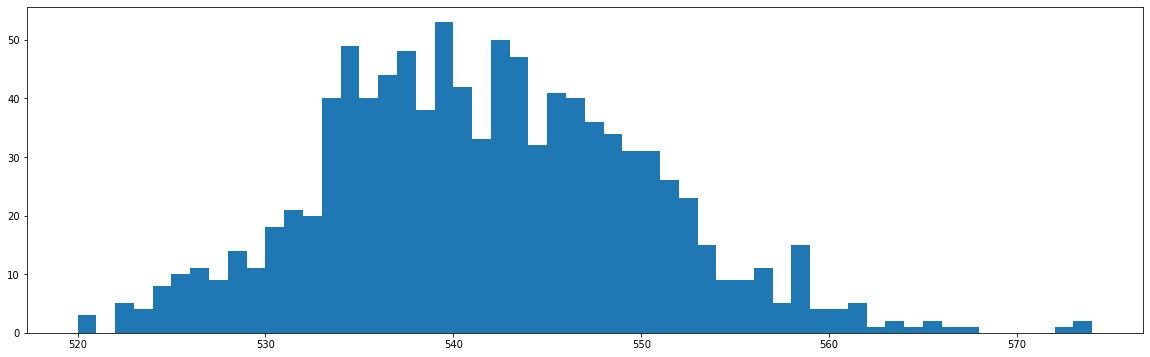

In [28]:
plt.figure(figsize=(20, 6))
plt.hist(T_array, range(min(T_array), 1+max(T_array)))
#plt.xticks(range(min(T_array), 1+max(T_array)))
#plt.title(str(num) + ' bins')
print(np.mean(T_array))

In [80]:
def show_traversal(idx):
    results = simulation_outputs[idx]
    
    x_ip = [0, ell]
    y_ip = [0, 0]

    # plot points here
    plt.figure(figsize=(14, 14))
    plt.margins(0.001)
    plt.xlim(-0.05, ell + 0.05)
    plt.ylim(-0.5 * ell , 0.5 * ell )

    plt.scatter(results['X'], results['Y'], s=2, c='red')
    plt.scatter(x_ip, y_ip, s=20, c='gold')
    
    path_edges = []
    for j in range(len(results['X'])-1):
        path_edges.append(np.array([[results['X'][j], results['Y'][j]], [results['X'][j+1], results['Y'][j+1]]]))
    path_edges = np.array(path_edges)
    for edge in path_edges:
        xs, ys = edge.T
        plt.plot(xs, ys, 'b-', linewidth=0.5, alpha=0.5)
    
    plt.title('simulation ' + str(idx))
    plt.show()

In [81]:
interact(show_traversal, idx=widgets.IntSlider(min=1, max=1000, step=1, value=1))

interactive(children=(IntSlider(value=1, description='idx', max=1000, min=1), Output()), _dom_classes=('widget…

<function __main__.show_traversal(idx)>

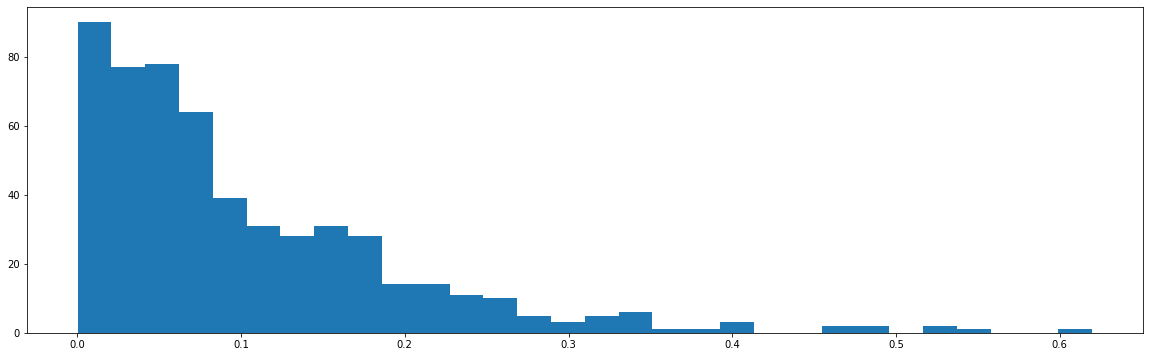

In [79]:
plt.figure(figsize=(20, 6))
plt.hist(simulation_outputs[4]['Theta'][1:], bins=30)
plt.show()

In [96]:
lengths_free = []
for k in simulation_outputs.keys():
    lengths_free.append(simulation_outputs[k]['length'])
    
lengths_free = np.array(lengths_free)

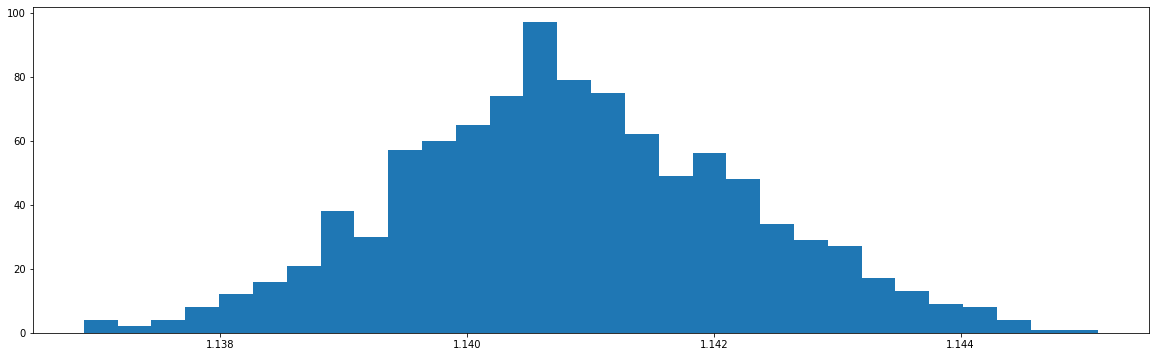

1.1408436054852436


In [85]:
plt.figure(figsize=(20, 6))
plt.hist(lengths, bins=30)
plt.show()

print(np.mean(lengths))

In [86]:
ell

1.1313708498984762

In [90]:
filename = 'slurm scripts/data/07-06-20/path_points/'

In [91]:
points = []
distances = []
lengths_based = []
counts = []

T_n_indices = defaultdict(list)

for i in range(1,1001):
    #if distances[i] == float('inf'):
    #    S_n.append(float('inf'))
    #    continue
    f = open(filename+str(i)+'-dim2-n1000000_pathpoints.pkl', "rb")
    pathpoints = pickle.load(f)
    points.append(pathpoints)
    s_n = 0
    for j in range(len(pathpoints)-2):
        s_n += np.linalg.norm(pathpoints[j+1] - pathpoints[j])
    lengths_based.append(s_n)
    distances.append(s_n + np.linalg.norm(pathpoints[-1] - pathpoints[-2]))
    counts.append(len(pathpoints)-2)
    T_n_indices[len(pathpoints)-2].append(i)
    
    if pathpoints[-1][0] != 0.9 or pathpoints[-1][1] != 0.9:
        print(i)

        
distances = np.array(distances)
lengths_based = np.array(lengths_based)
counts = np.array(counts)

In [93]:
# statistics on length

print(describe(lengths_based))
print(describe(lengths_free))

DescribeResult(nobs=1000, minmax=(1.1386894714459912, 1.1494309343480296), mean=1.1433867143714047, variance=2.6997702476019394e-06, skewness=0.26824564636951004, kurtosis=0.018551549386232047)
DescribeResult(nobs=1000, minmax=(1.1368960052117723, 1.1451161076214944), mean=1.1408436054852436, variance=1.95707727641456e-06, skewness=0.1018529113805514, kurtosis=-0.14919352581629575)


In [97]:
# statistics on length

asymp_based = []
for i in range(len(lengths_based)):
    asymp_based.append(lengths_based[i] * (counts[i] ** 0.5))
asymp_free = []
for i in range(len(lengths_free)):
    asymp_free.append(simulation_outputs[i+1]['length'] * (simulation_outputs[i+1]['T'] ** 0.5))

print(describe(asymp_based))
print(describe(asymp_free))

DescribeResult(nobs=1000, minmax=(25.283552297670226, 26.56543629547474), mean=25.957789409135604, variance=0.02745435373945311, skewness=0.20701421735574027, kurtosis=0.462434080459615)
DescribeResult(nobs=1000, minmax=(25.995467281823487, 27.312587587688636), mean=26.540831810982944, variance=0.04541984438641695, skewness=0.2451594408175094, kurtosis=0.10181655328939465)
